# EDA Cervix Cancer 

In [72]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import cv2
import skimage.io as io
import keras
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls 
py.init_notebook_mode(connected=True)
import random 
import shutil

from skimage.io import imread, imshow
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

from subprocess import check_output
print(check_output(["ls", "/home/kray/Practicum/train"]).decode("utf8"))

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

Type_1
Type_2
Type_3



249 photos of cervix type Type_1
781 photos of cervix type Type_2
450 photos of cervix type Type_3


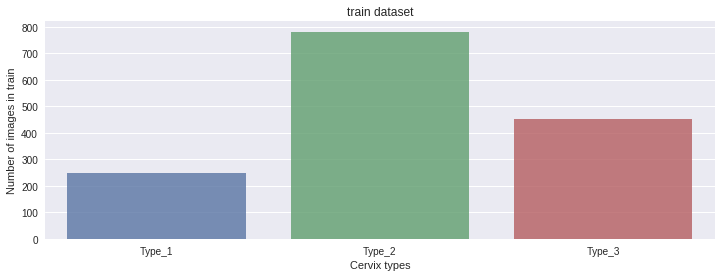

In [21]:
# Number of images for each cervix type.
sub_folders = check_output(["ls", "/home/kray/Practicum/train"]).decode("utf8").strip().split('\n')
count_dict = {}
for sub_folder in sub_folders:
    num_of_files = len(check_output(["ls", "/home/kray/Practicum/train/"+sub_folder]).decode("utf8").strip().split('\n'))
    print("{0} photos of cervix type {1}".format(num_of_files, sub_folder))
                            
    count_dict[sub_folder] = num_of_files
                            
plt.figure(figsize=(12,4))
sns.barplot(list(count_dict.keys()), list(count_dict.values()), alpha = 0.8)
plt.xlabel('Cervix types', fontsize = 11)
plt.ylabel('Number of images in train', fontsize = 11)
plt.title('train dataset')
                            
plt.show()


In [22]:
num_test_files = len(check_output(["ls", "/home/kray/Practicum/test/"]).decode("utf8").strip().split('\n'))
print("Number of test images present:", num_test_files)

Number of test images present: 512


In [24]:
train_path = "/home/kray/Practicum/train/"
sub_folders = check_output(["ls", train_path]).decode("utf8").strip().split('\n')
different_file_sizes = {}
for sub_folder in sub_folders:
    file_names = check_output(["ls", train_path+sub_folder]).decode("utf8").strip().split('\n')
    for file_name in file_names:
        im_array = imread(train_path+sub_folder+"/"+file_name)
        size = "_".join(map(str,list(im_array.shape)))
        different_file_sizes[size] = different_file_sizes.get(size,0) + 1



In [30]:
plt.figure(figsize=(12,4))
#sns.barplot(list(different_file_sizes.values()), list(different_file_sizes.keys()), alpha=0.8)
import pprint
pprint.pprint(different_file_sizes)
#plt.ylabel('Image size', fontsize = 11)
#plt.xlabel('Number of images in train', fontsize = 11)
#plt.title("Image sizes present in train dataset")
#plt.show()

{'2448_3264_3': 29,
 '3088_4128_3': 1,
 '3096_4128_3': 14,
 '3264_2448_3': 702,
 '4128_2322_3': 17,
 '4128_3096_3': 677,
 '4160_3120_3': 34,
 '640_480_3': 6}


In [64]:
#Split data into training and validation sets
allFiles = glob.glob('/home/kray/Practicum/train/*/*')

split_point = int(round(0.7*len(allFiles)))
random.shuffle(allFiles)

train_list = allFiles[:split_point]
valid_list = allFiles[split_point:]
print('Train images: {}'.format(len(train_list)))
print('Validation images {}'. format(len(valid_list)))

#Divy them into their own directories
train_data_path = '/home/kray/Practicum/train_data'
validation_data_path = '/home/kray/Practicum/valid_data'
if not os.path.exists(train_data_path):
    os.makedirs(train_data_path)
if not os.path.exists(validation_data_path):
    os.makedirs(validation_data_path)

for fpath in train_list:
    basename = fpath.split('/')[-2:]
    dest = '/'.join([train_data_path] +basename)
    if not os.path.exists('/'.join(dest.split('/')[:-1])):
        os.makedirs('/'.join(dest.split('/')[:-1]))
    shutil.copyfile(fpath, '/'.join([train_data_path] +basename))
for fpath in valid_list:
    basename = fpath.split('/')[-2:]
    dest = '/'.join([validation_data_path] +basename)
    if not os.path.exists('/'.join(dest.split('/')[:-1])):
        os.makedirs('/'.join(dest.split('/')[:-1]))
    shutil.copyfile(fpath, '/'.join([validation_data_path] +basename))

Train images: 1036
Validation images 444


# Model

In [65]:
#dimensions of images
img_width, img_height = 224, 224

In [66]:
# used to rescale the pixel values from [0, 224] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./224)

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_path,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_path,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1036 images belonging to 3 classes.
Found 444 images belonging to 3 classes.


In [67]:
#Small conv net
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [73]:
#model.compile(loss='binary_crossentropy',
              #optimizer='rmsprop',
              #metrics=['accuracy'])

sgd = SGD(lr=0.01, decay=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['acc']) 

In [74]:
#training

nb_epoch = 1
nb_train_samples = 1036
nb_validation_samples = 444

In [83]:
#model.fit_generator(
        #train_generator,
        #samples_per_epoch = nb_train_samples,
        #nb_epoch=nb_epoch,
        #validation_data = validation_generator,
        #nb_val_samples=nb_validation_samples)
        
model.fit(train_data_path, validation_data_path, batch_size=32, nb_epoch=5) 

TypeError: Error when checking model input: data should be a Numpy array, or list/dict of Numpy arrays. Found: /home/kray/Practicum/train_data...

In [ ]:
model.save_weights('models/basic_cnn_1_epoch.h5')

In [ ]:
#Evaluating on validation set

In [ ]:
#Computing loss and accuracy 
model.evaluate_generator(validation_generator, nb_validation_samples)

In [ ]:
#Data augmentation for improving model by applying random transformation to the train set. 
#reduces overfitting 

# Confusion Matrix

# Next Steps

1. Create an ensembe with pre-trained models: VGG16, ResNet_V2, and Inception_V3, then fine tune the top layers of the pre-trained networks. 
https://gihub.com/tensorflow/models/blob/master/slim/README.md#Pretrained

2. Experiment with more k-folds on the training images

3. Explore bounding box annotations 

4. Train and test the improved model on the additional images and second relase images

5. Incorrporate additional visualizations